In [48]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.applications import InceptionV3
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D
import kagglehub
import matplotlib.pyplot as plt

In [7]:
# Step 1: Download Dataset
dataset_path = kagglehub.dataset_download("salader/dogs-vs-cats")
print("Dataset downloaded to:", dataset_path)

Dataset downloaded to: /kaggle/input/dogs-vs-cats


In [8]:
train_dir = "/kaggle/input/dogs-vs-cats/train"
test_dir = "/kaggle/input/dogs-vs-cats/test"

In [68]:
# Step 2: Data Preprocessing
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

Found 20000 files belonging to 2 classes.


In [69]:
val_ds = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

Found 5000 files belonging to 2 classes.


In [70]:
# Normalize images
normalization_layer = keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [12]:
# Step 3: Load VGG16 Base Model
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Fine-tune from block5_conv1 onwards
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    layer.trainable = set_trainable

In [14]:
# Step 4: Build the Full Model
model = Sequential([
    conv_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [15]:
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

In [17]:
# Step 5: Train the Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=11
)

Epoch 1/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 165s 263ms/step - accuracy: 0.8635 - loss: 0.2964 - val_accuracy: 0.9544 - val_loss: 0.1159
Epoch 2/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 205s 268ms/step - accuracy: 0.9652 - loss: 0.0878 - val_accuracy: 0.9652 - val_loss: 0.0918
Epoch 3/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 268ms/step - accuracy: 0.9851 - loss: 0.0506 - val_accuracy: 0.9688 - val_loss: 0.0785
Epoch 4/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 153s 245ms/step - accuracy: 0.9933 - loss: 0.0275 - val_accuracy: 0.9702 - val_loss: 0.0779
Epoch 5/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 167s 267ms/step - accuracy: 0.9980 - loss: 0.0124 - val_accuracy: 0.9706 - val_loss: 0.0837
Epoch 6/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 168s 268ms/step - accuracy: 0.9992 - loss: 0.0052 - val_accuracy: 0.9702 - val_loss: 0.0896
Epoch 7/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 187s 245ms/step - accuracy: 0.9992 - loss: 0.0042 - val_accuracy: 0.9684 - val_loss: 0.0953
Epoch 8/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 153s 244ms/step - accuracy: 0.9997 -

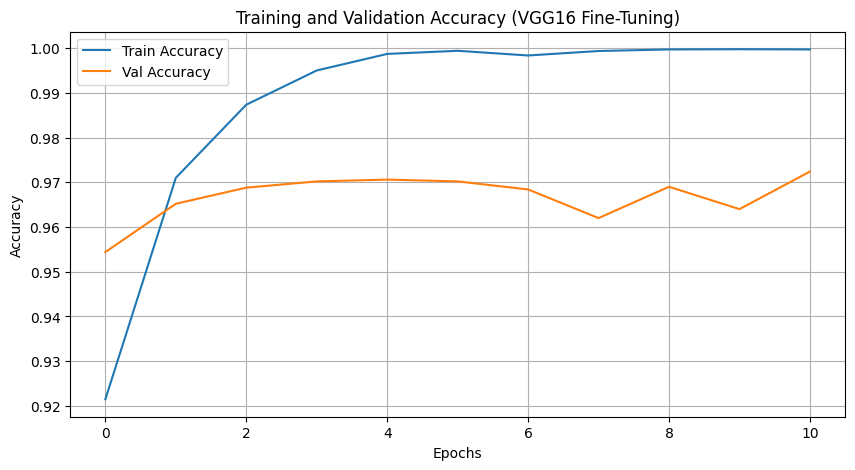

In [19]:
# Step 6: Plot The Training History of VGG16
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy (VGG16 Fine-Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# Do the same for ResNet50
# TensorFlow/Keras does not officially provide a pre-trained ResNet32 model
# but for the sake of fine-tuning using a ResNet-based architecture, we can use ResNet50

In [50]:
# Load ResNet50 Base Model (no top layer)
resnet_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [51]:
# Fine-tune last few layers
resnet_base.trainable = True
for layer in resnet_base.layers[:-50]:
    layer.trainable = False

In [56]:
# Build the Model
model_resnet = Sequential([
    resnet_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_resnet.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

In [58]:
# Step 5: Train the Model
history_resnet = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=11
)

Epoch 1/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 172ms/step - accuracy: 0.6996 - loss: 0.5750 - val_accuracy: 0.5996 - val_loss: 0.8607
Epoch 2/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 173ms/step - accuracy: 0.7681 - loss: 0.4810 - val_accuracy: 0.7552 - val_loss: 0.4968
Epoch 3/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 160ms/step - accuracy: 0.7885 - loss: 0.4458 - val_accuracy: 0.6814 - val_loss: 0.6863
Epoch 4/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 173ms/step - accuracy: 0.8110 - loss: 0.4096 - val_accuracy: 0.7852 - val_loss: 0.4704
Epoch 5/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 175ms/step - accuracy: 0.8228 - loss: 0.3888 - val_accuracy: 0.7556 - val_loss: 0.5468
Epoch 6/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 133s 160ms/step - accuracy: 0.8323 - loss: 0.3642 - val_accuracy: 0.7762 - val_loss: 0.5057
Epoch 7/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 160ms/step - accuracy: 0.8517 - loss: 0.3331 - val_accuracy: 0.7964 - val_loss: 0.4703
Epoch 8/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 160ms/step - accuracy: 0.8655 -

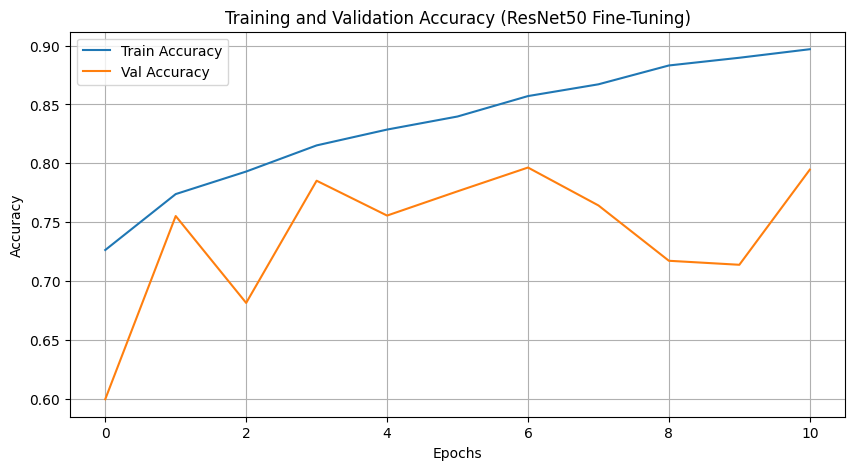

In [59]:
# Plot The Training History of ResNet50
plt.figure(figsize=(10, 5))
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy (ResNet50 Fine-Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
# Do the same for InceptionV3

In [79]:
# Load InceptionV3 Base Model
inception_base = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [80]:
# Fine-tune top layers
inception_base.trainable = True
for layer in inception_base.layers[:-100]:
    layer.trainable = False

In [83]:
# Build the Model
model = Sequential([
    inception_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

In [84]:
# Train the Model
history_inception = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=11
)

Epoch 1/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 119s 132ms/step - accuracy: 0.9348 - loss: 0.1952 - val_accuracy: 0.9882 - val_loss: 0.0328
Epoch 2/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 73s 116ms/step - accuracy: 0.9890 - loss: 0.0315 - val_accuracy: 0.9886 - val_loss: 0.0298
Epoch 3/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 115ms/step - accuracy: 0.9957 - loss: 0.0156 - val_accuracy: 0.9888 - val_loss: 0.0307
Epoch 4/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 115ms/step - accuracy: 0.9983 - loss: 0.0072 - val_accuracy: 0.9894 - val_loss: 0.0319
Epoch 5/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 116ms/step - accuracy: 0.9990 - loss: 0.0041 - val_accuracy: 0.9888 - val_loss: 0.0316
Epoch 6/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 115ms/step - accuracy: 0.9987 - loss: 0.0036 - val_accuracy: 0.9882 - val_loss: 0.0328
Epoch 7/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 116ms/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.9878 - val_loss: 0.0380
Epoch 8/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 115ms/step - accuracy: 0.9996 - loss: 

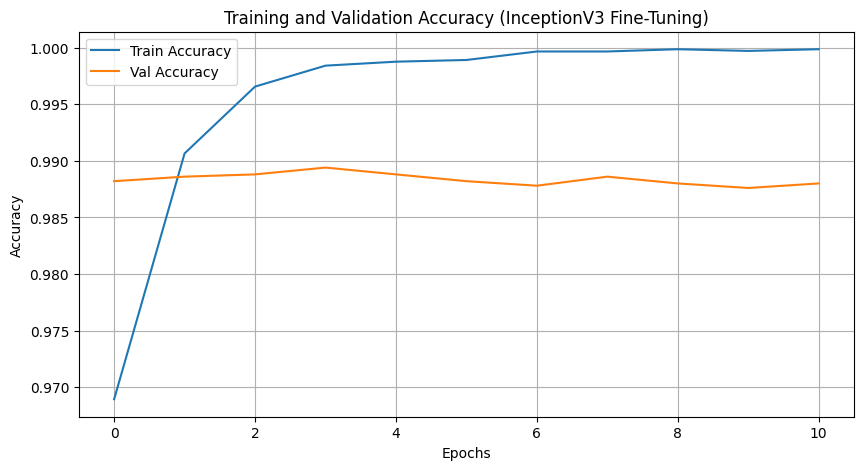

In [85]:
# Plot The Training History of InceptionV3
plt.figure(figsize=(10, 5))
plt.plot(history_inception.history['accuracy'], label='Train Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy (InceptionV3 Fine-Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [88]:
# Do the same for AlexNet

In [89]:
# Since AlexNet is not included in Keras by default
# I manually define it using Keras layers to simulate the original AlexNet architecture.

In [90]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Clear previous model sessions
tf.keras.backend.clear_session()

# Define AlexNet-like model
alexnet_model = Sequential([
    Conv2D(96, kernel_size=(11,11), strides=4, activation='relu', input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=2),

    Conv2D(256, kernel_size=(5,5), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=2),

    Conv2D(384, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(384, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3,3), strides=2),

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

In [91]:
# Compile the model
alexnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [92]:
# Train the model
history_alexnet = alexnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=11
)

Epoch 1/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.6194 - loss: 0.6870 - val_accuracy: 0.6446 - val_loss: 0.6190
Epoch 2/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.7644 - loss: 0.4830 - val_accuracy: 0.8148 - val_loss: 0.3995
Epoch 3/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 69ms/step - accuracy: 0.8474 - loss: 0.3481 - val_accuracy: 0.7160 - val_loss: 0.6014
Epoch 4/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 65ms/step - accuracy: 0.8824 - loss: 0.2752 - val_accuracy: 0.8642 - val_loss: 0.3152
Epoch 5/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.9040 - loss: 0.2263 - val_accuracy: 0.8554 - val_loss: 0.3307
Epoch 6/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.9233 - loss: 0.1790 - val_accuracy: 0.8274 - val_loss: 0.4504
Epoch 7/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.9421 - loss: 0.1394 - val_accuracy: 0.8902 - val_loss: 0.3267
Epoch 8/11
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 68ms/step - accuracy: 0.9556 - loss: 0.1092 - 

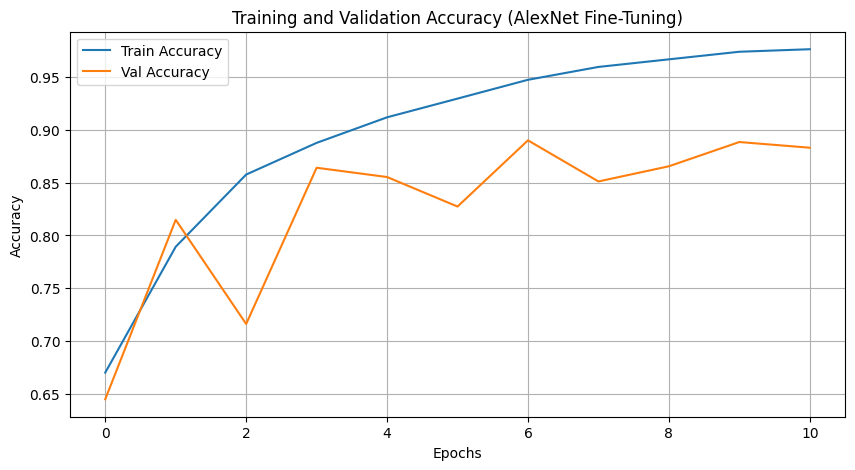

In [93]:
# Plot The Training History of AlexNet
plt.figure(figsize=(10, 5))
plt.plot(history_alexnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_alexnet.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy (AlexNet Fine-Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [94]:
# Build a comparison plot of accuracy plots

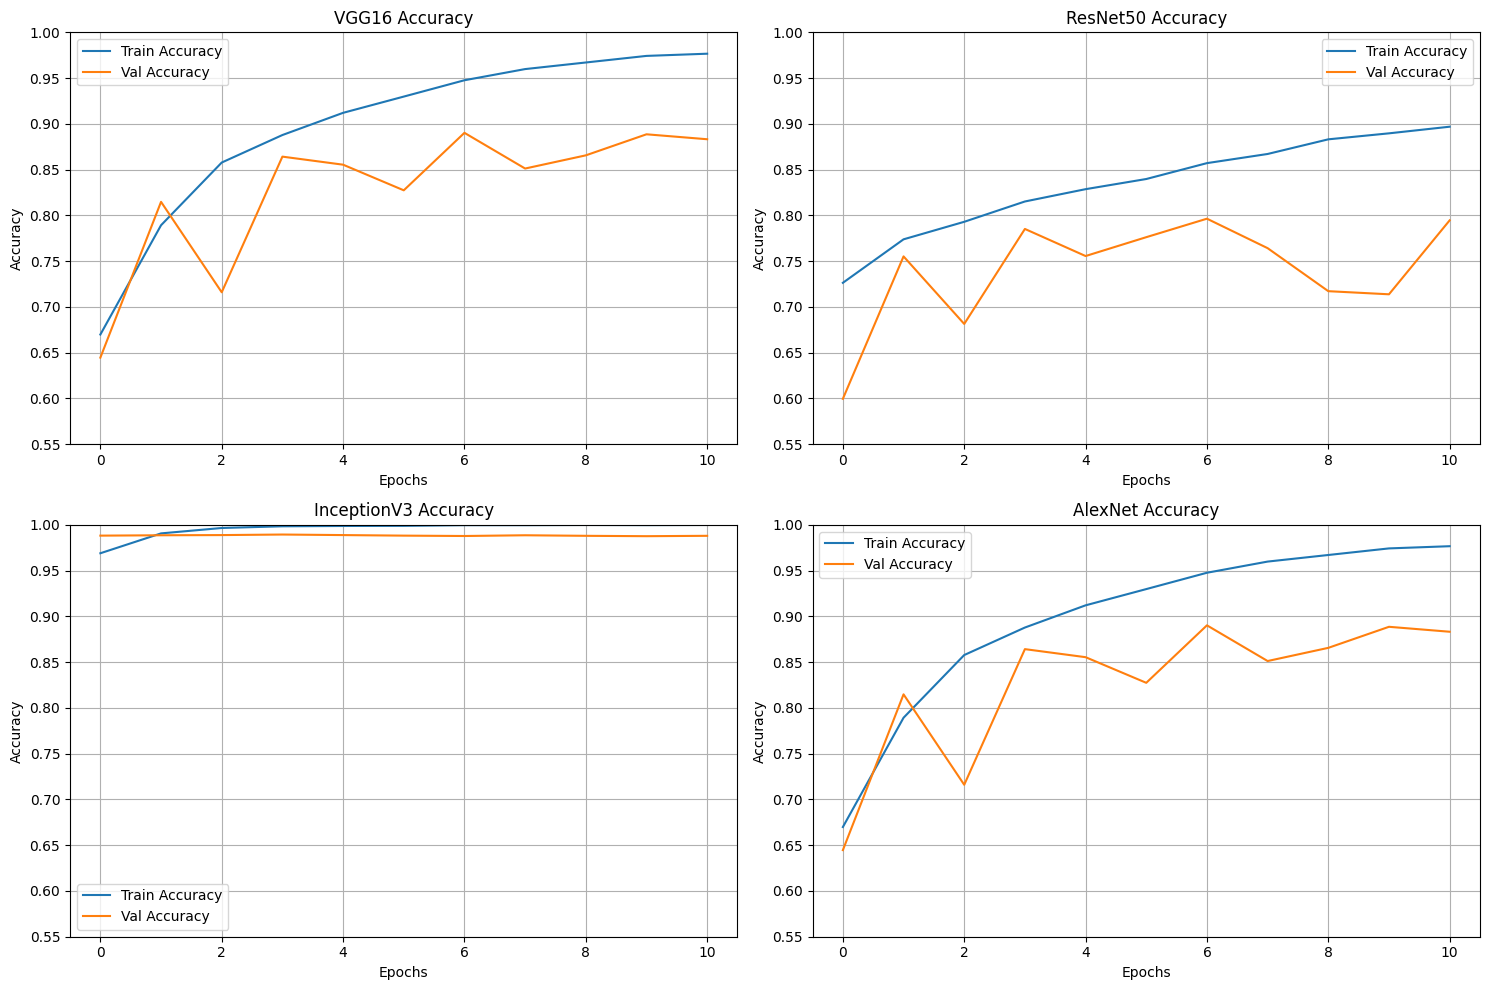

In [102]:
model_histories = [
    ("VGG16", history),
    ("ResNet50", history_resnet),
    ("InceptionV3", history_inception),
    ("AlexNet", history_alexnet)
]

# Create 2x2 subplot grid
plt.figure(figsize=(15, 10))

for idx, (name, history) in enumerate(model_histories, 1):
    plt.subplot(2, 2, idx)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0.55, 1.0)  # Set fixed y-axis limits for all plots
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()